# Bird Data Science Challenge
## Ghazal Erfani

### __Goal__: Predict which Birds will soon require maintenance. 

### __Exploratory Data Analysis Observations__: 
- The dataset consists of 50,000 observations and 11 features pertaining to the Bird device, user, and ride. 
- There are no missing values. 
- There are 500 unique Birds, 2 unique Bird Models, and 100 unique riders. 
- The dataset is imbalanced: 69% of rides have not triggered maintenance. This may require downsampling or upsampling to balance the dataset prior to modeling. 
- On average, each rider takes 500 rides. 
- Rider’s age, rating, distance travelled, and time travelled does not differ greatly between rides that trigger maintenance and those that do not. 
- There are outliers in time travelled (as per boxplot). 

### __Data Preparation__:
- As part of Exploratory Data Analysis, 2 new features were created:

    - *time_travelled_minutes*: time travelled during ride.
    - *distance_travelled*: distance travelled during ride.
        
    
- To improve model performance, 3 new features were created: 

    - *total_distance_travelled*: total distance Bird has travelled. 
    - *count_past_rides*: total number of rides Bird has had in the past. 
    - *count_past_rides_with_maintenance*: total number of rides Bird has had in the past that have triggered maintenance. Note: there are some outliers here (as per boxplot).         
        
        
- Scatter plots were used to view relationships among features. Given the observed linear relationship between *count_past_rides* and *count_past_rides_with_maintenance*, *count_past_rides* was not included in modeling to reduce collinearity effects. 


- Using the Interquartile Range Rule, 3,017 outliers were identified. Since these observations accounted 6% of the data, they were removed. If there had been more outliers, I would have considered winsorization to minimize the loss of data. 


- For modeling, 5 continuous features and 3 discrete features were selected. Discrete features were converted to dummy variables. 


- Data was split into training and test sets. Training dataset was downsampled to ensure balance. Datasets were standardized. 

### __Modeling__:
- A total of 6 classification models were used: 

    - Dummy classifier (a baseline model that uses training set’s class distribution)
    - Naïve Bayes
    - Logistic Regression
    - Decision Tree
    - Random Forest
    - Support Vector Machine (SVM)
    

- To streamline modeling, a function was created to fit and evaluate models. 

    - Takes in a model  and a set of parameters and uses grid search with cross validation to tune the hyperparameters and find the optimal model. 
    - Prints the optimal model parameters, and several performance metrics: accuracy, Receiving Operating Characteristic Area Under the Curve (ROC AUC), and F1-score, and the confusion matrix. 
    - Returns information about the model to be used for plotting ROC curves. 


- In this analysis, the cost of having a false negative is high: incorrectly predicting that a Bird does not require maintenance is worse than incorrectly predicting that a Bird does require maintenance. Thus, we aim to increase the sensitivity/recall (True Positive Rate) of our model. As a result, the model with the highest ROC AUC score will be selected as the best model. 


- As one can see by the printed ROC AUC metrics and the visualized ROC Curves, the Decision Tree model is the best model, with an ROC AUC of 0.62 and an F1-score of 0.54. 

    - Compared to our baseline model with an ROC AUC of 0.51 and an F1-score of 0.40, this Decision Tree model improves prediction of Birds that will require maintenance. 
    - Note that we are not only using accuracy score to measure model performance because accuracy alone is too simplistic and does not decompose the different types of correct and incorrect decisions a classifier makes. 
        

- Based on feature importance of this Decision Tree model, we conclude that time travelled on that ride, total distance Bird has travelled, and distance travelled on that ride are the most important features to predict required maintenance, respectively. 



### __Next Steps__:
Given more time, I would consider exploring the following areas: 
- To improve model performance:

    - I would aim to incorporate better features into the model: 

        - *Total time travelled*: Given that time travelled on that Bird ride was the most important feature in our best model, I would consider creating this as new feature that captures the total time that a Bird has travelled. 
        - *Average speed travelled*: If possible, I would consider collecting this data from the device for each ride. If not possible, I would consider *using distance travelled on that ride* divided by *time travelled on that ride* as a good estimate for average speed travelled on that ride. The shortcoming of this calculation is that it would include time during which the device was idle, so it may not accurately represent the average speed of the device during that ride.
        - *Type of road travelled on*: Given that different road types (i.e. highway vs concrete load road vs brick local road) may have varying effects on the device condition, I would consider collecting this data from the device to give us better insight into its wear and tear. 
     
    - I would consider using ensemble methods such as bagging, boosting, or stacking to reduce bias and variance of the model and improve predictions. 
         
        
- To improve the readability and reproducibility of this workflow, I would consider using Sklearn’s Pipeline tool.


- To improve upon recommendations to the business, I would consider the possibility of collecting data about the type of maintenance that was required. This could help provide more targeted predictions: not only when maintenance is required, but also how much effort the maintenance entails. 

### __Resources__:
- Stack Overflow
- StackExchange: Cross Validated
- Scikit-learn Documentation 

In [1]:
## Required Imports

# Data Cleaning
import pandas as pd
import numpy as np
import datetime

# Visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns

# Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# Data Modeling
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Model Evaluation
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, confusion_matrix

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

### Load Data

In [2]:
df = pd.read_csv('rides.csv')

In [3]:
# convert timestamps from Epoch format to datetime (GMT)
df['start_timestamp']  = pd.to_datetime(df['start_timestamp'],unit='s')
df['end_timestamp']  = pd.to_datetime(df['end_timestamp'],unit='s')

## Exploratory Data Analysis

### What is size of dataset?

In [4]:
df.shape

(50000, 11)

### What features are available?

In [5]:
# add new features distance_travelled, time_travelled, time_travelled_minutes
df['distance_travelled'] = df['end_odometer'] - df['start_odometer']
df['time_travelled'] = df['end_timestamp'] - df['start_timestamp']
df['time_travelled_minutes'] = round(df['time_travelled'] / np.timedelta64(1, 'm') ,2)

In [6]:
df.dtypes

bird_id                                 int64
bird_model_id                           int64
start_odometer                        float64
end_odometer                          float64
start_timestamp                datetime64[ns]
end_timestamp                  datetime64[ns]
rider_id                                int64
rider_age                               int64
ride_rating                             int64
ride_neighborhood                      object
ride_triggered_maintenance               bool
distance_travelled                    float64
time_travelled                timedelta64[ns]
time_travelled_minutes                float64
dtype: object

### Are there missing values?

In [7]:
print(df.isnull().values.any())

False


### How many unique (1) Birds, (2) Bird Models, and (3) are there?

In [8]:
print('There are %d unique Birds.' %df['bird_id'].nunique())
print('There are %d unique Bird Models.' %df['bird_model_id'].nunique())
print('There are %d unique riders.' %df['rider_id'].nunique())

There are 500 unique Birds.
There are 2 unique Bird Models.
There are 100 unique riders.


### How many Birds require maintenance?

In [9]:
df['ride_triggered_maintenance'].value_counts().to_frame()

,ride_triggered_maintenance
False,34584
True,15416


### How many rides does each rider take?

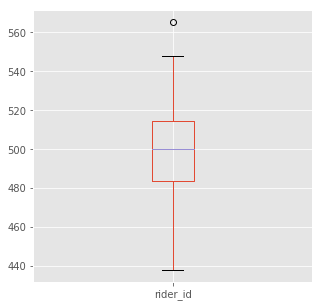

On average, each rider takes 500 rides.


In [10]:
pd.DataFrame(df['rider_id'].value_counts()).boxplot(figsize=(5,5))
plt.show()
print("On average, each rider takes %d rides." %df['rider_id'].value_counts().mean())

### How does rider's age, rating, distance travelled, and time travelled differ between those that trigger maintenance and those that do not?

In [11]:
df_triggered_maintenance = df[df['ride_triggered_maintenance']==True]
df_didnot_trigger_maintenance = df[df['ride_triggered_maintenance']==False]

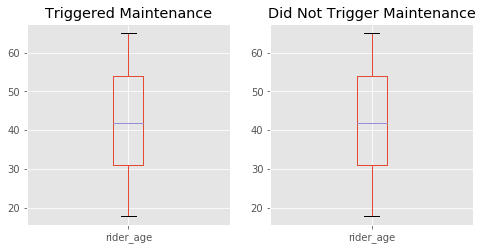

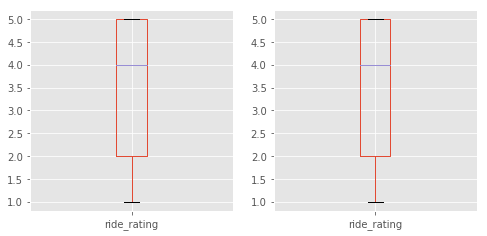

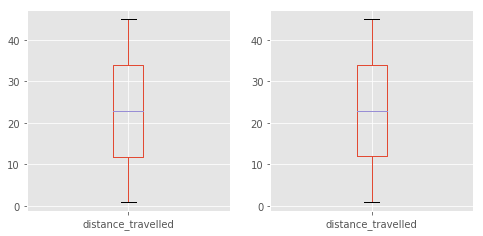

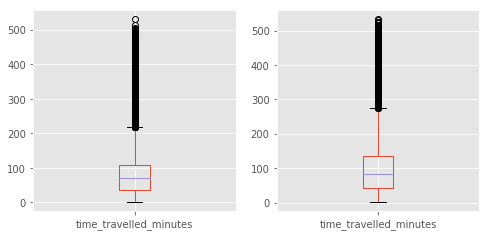

In [12]:
columns_for_boxplot = ['rider_age', 'ride_rating', 'distance_travelled', 'time_travelled_minutes']
for i, j, c in zip([1,3,5,7], [2,4,6,8] , columns_for_boxplot):
    fig = plt.figure(figsize=(8,17))
    ax1 = fig.add_subplot(4,2,i)
    if i==1: ax1.set_title("Triggered Maintenance")
    df_triggered_maintenance.boxplot(column=[c], ax=ax1)
    ax2 = fig.add_subplot(4,2,j)
    if j==2: ax2.set_title("Did Not Trigger Maintenance")
    df_didnot_trigger_maintenance.boxplot(column=[c], ax=ax2)

## Data Preparation

In [14]:
df.shape

(50000, 14)

### Create Input New Features

In [15]:
# new input feature: total distance that bird has traveled
df['total_distance_travelled'] = df['end_odometer']

In [16]:
# new input feature: count of past rides that bird has had
df_sorted = df.sort_values(by=['bird_id', 'start_timestamp'])
df_sorted['count_past_rides'] = df_sorted.groupby('bird_id')['start_timestamp'].cumcount()-1

In [17]:
# new input feature: count of rides that bird has had that have required maintenance
df_sorted['count_past_rides_with_maintenance'] = df_sorted.groupby('bird_id')['ride_triggered_maintenance'].cumsum()
df_sorted['count_past_rides_with_maintenance'] = np.where(df_sorted['ride_triggered_maintenance']==True, \
                                                          df_sorted['count_past_rides_with_maintenance'] - 1, \
                                                          df_sorted['count_past_rides_with_maintenance'])
df = df_sorted

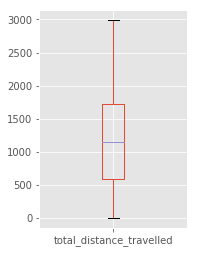

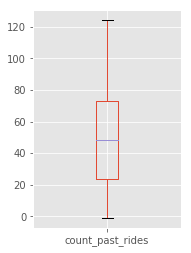

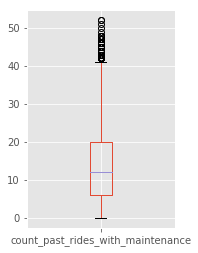

In [18]:
# plot boxplots of new continuous features to check for outliers
columns_for_boxplot = ['total_distance_travelled', 'count_past_rides', 'count_past_rides_with_maintenance']
for i, c in zip([1,2,3], columns_for_boxplot):
    fig = plt.figure(figsize=(9,4))
    ax = fig.add_subplot(1,3,i)
    df_sorted.boxplot(column=[c], ax=ax)

In [144]:
# # option: plot scatter plots to see feature relationships
# continuous_features = ['rider_age', 'distance_travelled', 'time_travelled_minutes', 'total_distance_travelled', 'count_past_rides', 'count_past_rides_with_maintenance']
# pairplot = sns.pairplot(df[continuous_features])

### Handle Outliers

In [19]:
# identify time_travelled_minutes outliers (those outside of IQR)
Q1 = df['time_travelled_minutes'].quantile(0.25)
Q3 = df['time_travelled_minutes'].quantile(0.75)
IQR = Q3 - Q1
df_time_travelled_minutes_outliers =  df[(df['time_travelled_minutes'] < (Q1 - 1.5*IQR)) |(df['time_travelled_minutes'] > (Q3 + 1.5*IQR))]
print('There are %d time_travelled_minutes outliers.' %df_time_travelled_minutes_outliers.shape[0])

There are 2870 time_travelled_minutes outliers.


In [20]:
# remove time_travelled_minutes outliers
df_no_time_travelled_minutes_outliers = df[~((df['time_travelled_minutes'] < (Q1 - 1.5*IQR)) |(df['time_travelled_minutes'] > (Q3 + 1.5*IQR)))]
print('After removing some outliers, %d observations remain.' %df_no_time_travelled_minutes_outliers.shape[0])

After removing some outliers, 47130 observations remain.


In [21]:
# identify count_past_rides_with_maintenance outliers (those outside of IQR)
Q1 = df_no_time_travelled_minutes_outliers['count_past_rides_with_maintenance'].quantile(0.25)
Q3 = df_no_time_travelled_minutes_outliers['count_past_rides_with_maintenance'].quantile(0.75)
IQR = Q3 - Q1
df_count_past_rides_with_maintenance_outliers =  df_no_time_travelled_minutes_outliers[(df_no_time_travelled_minutes_outliers['count_past_rides_with_maintenance'] < (Q1 - 1.5*IQR)) |(df_no_time_travelled_minutes_outliers['count_past_rides_with_maintenance'] > (Q3 + 1.5*IQR))]
print('There are %d count_past_rides_with_maintenance outliers.' %df_count_past_rides_with_maintenance_outliers.shape[0])

There are 147 count_past_rides_with_maintenance outliers.


In [22]:
# remove count_past_rides_with_maintenance outliers
df_no_outliers = df_no_time_travelled_minutes_outliers[~((df_no_time_travelled_minutes_outliers['count_past_rides_with_maintenance'] < (Q1 - 1.5*IQR)) |(df_no_time_travelled_minutes_outliers['count_past_rides_with_maintenance'] > (Q3 + 1.5*IQR)))]
print('After removing remaining outliers, %d observations remain.' %df_no_outliers.shape[0])

After removing remaining outliers, 46983 observations remain.


### Select Features for Modeling

In [116]:
df_continuous_input_features = df_no_outliers[['rider_age', 'distance_travelled', 'time_travelled_minutes', 'total_distance_travelled', 'count_past_rides_with_maintenance']]
discrete_input_features = ['bird_model_id', 'ride_rating', 'ride_neighborhood']
df_discrete_input_features = pd.get_dummies(df_no_outliers[discrete_input_features].astype(str), prefix_sep = "::")

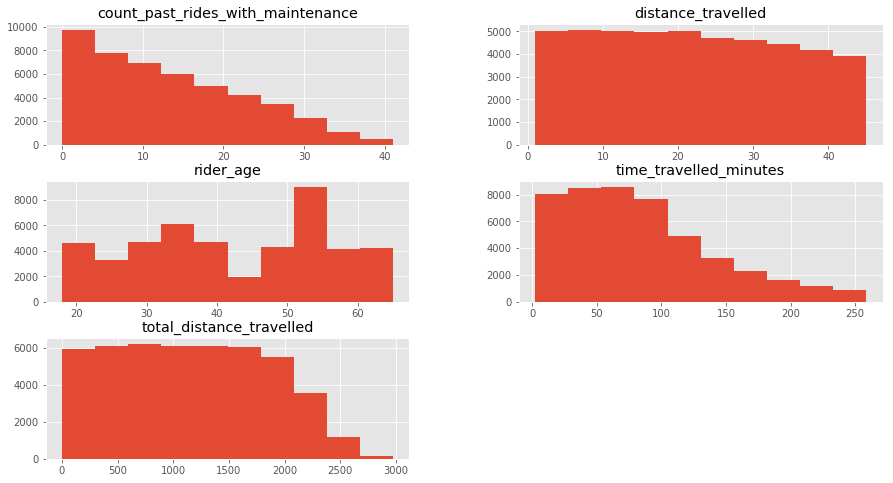

In [117]:
feature_distribution = df_continuous_input_features.hist(figsize = (15,8))

In [118]:
df_model_features = pd.concat([df_continuous_input_features, df_discrete_input_features], axis=1)

### Split into Training and Test Data

In [119]:
X = df_model_features
y = df_no_outliers['ride_triggered_maintenance']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Balance Dataset

In [120]:
training_set = pd.concat([X_train, y_train], axis=1)
no_maintenance = training_set[training_set['ride_triggered_maintenance']==False]
maintenance = training_set[training_set['ride_triggered_maintenance']==True]

In [121]:
# option to upsample dataset
# upsampled = resample(maintenance, replace=True, n_samples=len(no_maintenance), random_state=0)
# upsampled_all = pd.concat([upsampled, no_maintenance])
# y_train = upsampled_all['ride_triggered_maintenance']
# X_train = upsampled_all.drop('ride_triggered_maintenance', axis=1)

In [122]:
downsampled = resample(no_maintenance, replace=False, n_samples=len(maintenance), random_state=0)
downsampled_all = pd.concat([downsampled, maintenance])
y_train = downsampled_all['ride_triggered_maintenance']
X_train = downsampled_all.drop('ride_triggered_maintenance', axis=1)

### Standardize Features

In [123]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [124]:
X_train.shape

(23494, 23)

## Modeling

In [125]:
fitted_models = []

### Baseline Model: Dummy Classifier

In [126]:
%%time
# stratified classifier uses the training data's class distribution to predict
model_label = 'Dummy Classifier'
dummy_classifier = DummyClassifier(strategy="stratified")
dummy_classifier.fit(X_train,y_train)
y_pred = dummy_classifier.predict(X_test)

roc = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy Score: %.4f" % accuracy_score(y_test, y_pred))
print("ROC AUC Score: %.4f" % roc_auc_score(y_test, y_pred))
print("F1 Score: %.4f" % f1_score(y_test, y_pred))
print("")
print("Confusion Matrix:")
print(cm)
print("")

color = 'black'
fitted_dummy_classifier = (roc, roc_auc, model_label, color)
fitted_models.append(fitted_dummy_classifier)

Accuracy Score: 0.5084
ROC AUC Score: 0.5081
F1 Score: 0.3951

Confusion Matrix:
[[3268 3156]
 [1464 1509]]

CPU times: user 20.4 ms, sys: 3.92 ms, total: 24.3 ms
Wall time: 22.2 ms


### Function to Fit & Evaluate Models

In [127]:
def fit_classifier(model, param_grid, model_label, color):
    '''
    This function fits a classification model by tuning hyperparameters and prints its evaluation metrics. 
    
    Inputs:
    model = sklearn model object
    model_label = string of model name to be used for plotting
    param_grid = dictionary or list of dictionaries of hyperparameters to be tuned
    color = string of color associated with model for plotting
    
    Outputs:
    roc = computed receiver operating characteristic to be used for plotting
    roc_auc = ROC area under the curve to be used for plotting
    model_label = string of model name to be used for plotting
    color = string of color associated with model for plotting
    '''
    
    clf = GridSearchCV(model,param_grid,cv=5)

    best_clf = clf.fit(X_train,y_train)

    print('Best Parameters: %s' %best_clf.best_params_) 
    print("")

    y_pred = best_clf.predict(X_test)
    roc = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print("Accuracy Score: %.4f" %accuracy)
    print("ROC AUC Score: %.4f" %roc_auc)
    print("F1 Score: %.4f" %f1)
    print("")
    print("Confusion Matrix:")
    print(cm)
    print("")
    
    
    return (roc, roc_auc, model_label, color)

### Naive Bayes

In [128]:
%%time
param_grid = {'var_smoothing': 10.0 ** np.arange(1,8)}
gnb = fit_classifier(GaussianNB(), param_grid, 'Naive Bayes', 'orange')
fitted_models.append(gnb)

Best Parameters: {'var_smoothing': 10000.0}

Accuracy Score: 0.5668
ROC AUC Score: 0.5760
F1 Score: 0.4675

Confusion Matrix:
[[3539 2885]
 [1186 1787]]

CPU times: user 614 ms, sys: 137 ms, total: 751 ms
Wall time: 798 ms


### Logistic Regression

In [129]:
%%time
param_grid = {"penalty": ["l1","l2"], "C": [1e-02, 1e-03, 1e-04, 1e-05, 1e-06, 1e-07]}
log_reg = fit_classifier(LogisticRegression(), param_grid, 'Logistic Regression', 'green')
fitted_models.append(log_reg)

Best Parameters: {'C': 0.01, 'penalty': 'l1'}

Accuracy Score: 0.5831
ROC AUC Score: 0.5892
F1 Score: 0.4790

Confusion Matrix:
[[3678 2746]
 [1172 1801]]

CPU times: user 2.58 s, sys: 163 ms, total: 2.74 s
Wall time: 1.42 s


### Decision Tree

In [130]:
%%time
param_grid = {'max_depth': range(1,51), 'min_impurity_decrease':np.linspace(0,0.001,9)}
dt = fit_classifier(DecisionTreeClassifier(), param_grid, 'Decision Tree', 'blue')
fitted_models.append(dt)

Best Parameters: {'max_depth': 13, 'min_impurity_decrease': 0.00025}

Accuracy Score: 0.5323
ROC AUC Score: 0.6247
F1 Score: 0.5424

Confusion Matrix:
[[2397 4027]
 [ 368 2605]]

CPU times: user 1min 54s, sys: 2.03 s, total: 1min 56s
Wall time: 1min 57s


### Random Forest

In [132]:
%%time
param_grid = {'n_estimators':[80],'criterion':['gini', 'entropy'], 'max_depth':range(1,15), 'min_impurity_decrease':np.linspace(0,0.001,9)}
rf = fit_classifier(RandomForestClassifier(), param_grid, 'Random Forest', 'purple')
fitted_models.append(rf)

Best Parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_impurity_decrease': 0.0, 'n_estimators': 80}

Accuracy Score: 0.5664
ROC AUC Score: 0.5973
F1 Score: 0.4986

Confusion Matrix:
[[3296 3128]
 [ 947 2026]]

CPU times: user 10min 1s, sys: 9.34 s, total: 10min 11s
Wall time: 10min 27s


### SVM

In [136]:
%%time
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]}, {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
svc = fit_classifier(SVC(), param_grid, 'SVM', 'pink')
fitted_models.append(svc)

Best Parameters: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Accuracy Score: 0.5371
ROC AUC Score: 0.6034
F1 Score: 0.5173

Confusion Matrix:
[[2716 3708]
 [ 642 2331]]

CPU times: user 2h 33min 53s, sys: 34.5 s, total: 2h 34min 27s
Wall time: 2h 35min 32s


### Visualize ROC Curves of Models

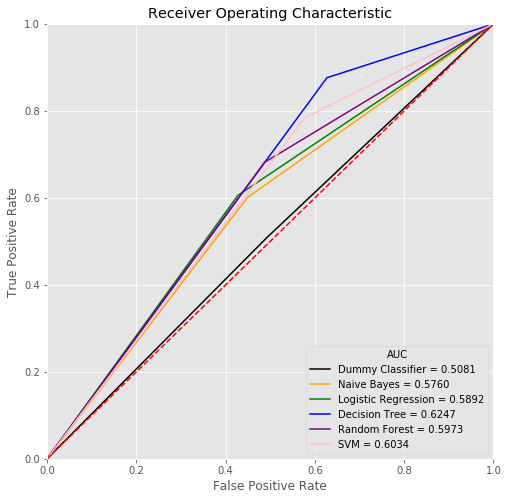

In [137]:
plt.figure(figsize = (8,8))

for fitted_model in fitted_models:
    fpr, tpr, thresholds = fitted_model[0]
    plt.plot(fpr, tpr, fitted_model[3], label = '%s = %0.4f' % (fitted_model[2], fitted_model[1]))
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right', title = 'AUC')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Fit Best Model

In [138]:
best_model = DecisionTreeClassifier(max_depth=13, min_impurity_decrease=0.00025)

best_model.fit(X_train,y_train)

y_pred = best_model.predict(X_test)
roc = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
    
print("Accuracy Score: %.4f" %accuracy)
print("ROC AUC Score: %.4f" %roc_auc)
print("F1 Score: %.4f" %f1)
print("")
print("Confusion Matrix:")
print(cm)
print("")

Accuracy Score: 0.5323
ROC AUC Score: 0.6247
F1 Score: 0.5424

Confusion Matrix:
[[2397 4027]
 [ 368 2605]]



### Get Feature Importance

In [141]:
feature_importance = pd.DataFrame(zip(df_model_features.columns, best_model.feature_importances_), columns = ['Feature','Feature Importance'])
feature_importance[feature_importance['Feature Importance'] != 0].sort_values(by=['Feature Importance'], ascending=False)

,Feature,Feature Importance
2,time_travelled_minutes,0.521072
3,total_distance_travelled,0.283094
1,distance_travelled,0.184449
9,ride_rating::3,0.006252
4,count_past_rides_with_maintenance,0.005133
